# Instituto Federal de Educação, Ciência e Tecnologia do Espírito Santo
# Aprendizado de Máquina
# Machine Learning
Docente: Francisco de Assis Boldt

Aluno: Petar Veljovic

# Aplicação para OCR

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
%matplotlib inline

from sklearn.model_selection               import train_test_split
from sklearn.metrics                       import confusion_matrix
from keras.utils                           import to_categorical 
from keras.models                          import Sequential
from keras.layers                          import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers                      import RMSprop
from keras.callbacks                       import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image  import ImageDataGenerator

sns.set(style='white', context='notebook', palette='deep')
np.random.seed(2)

In [78]:
# Obtem os dados

# ref: https://www.kaggle.com/competitions/digit-recognizer/data?select=train.csv
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
# ref: https://www.kaggle.com/competitions/digit-recognizer/data?select=test.csv
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

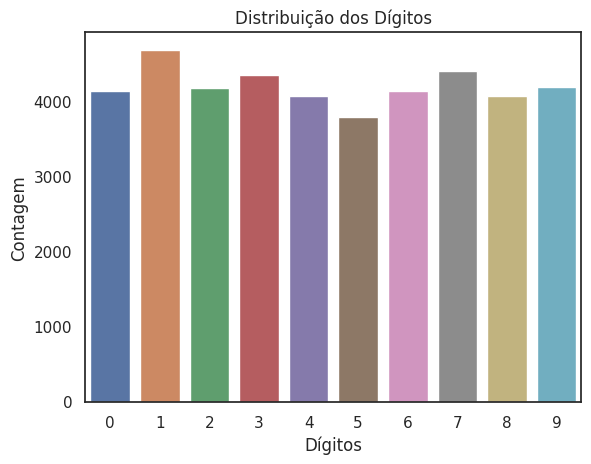

In [79]:
Y_train = train["label"]
df = train

X_train = train.drop(labels = ["label"],axis = 1) 

Y_train.value_counts()

sns.countplot(x='label', data=df)
plt.xlabel('Dígitos')
plt.ylabel('Contagem')
plt.title('Distribuição dos Dígitos')
plt.show()


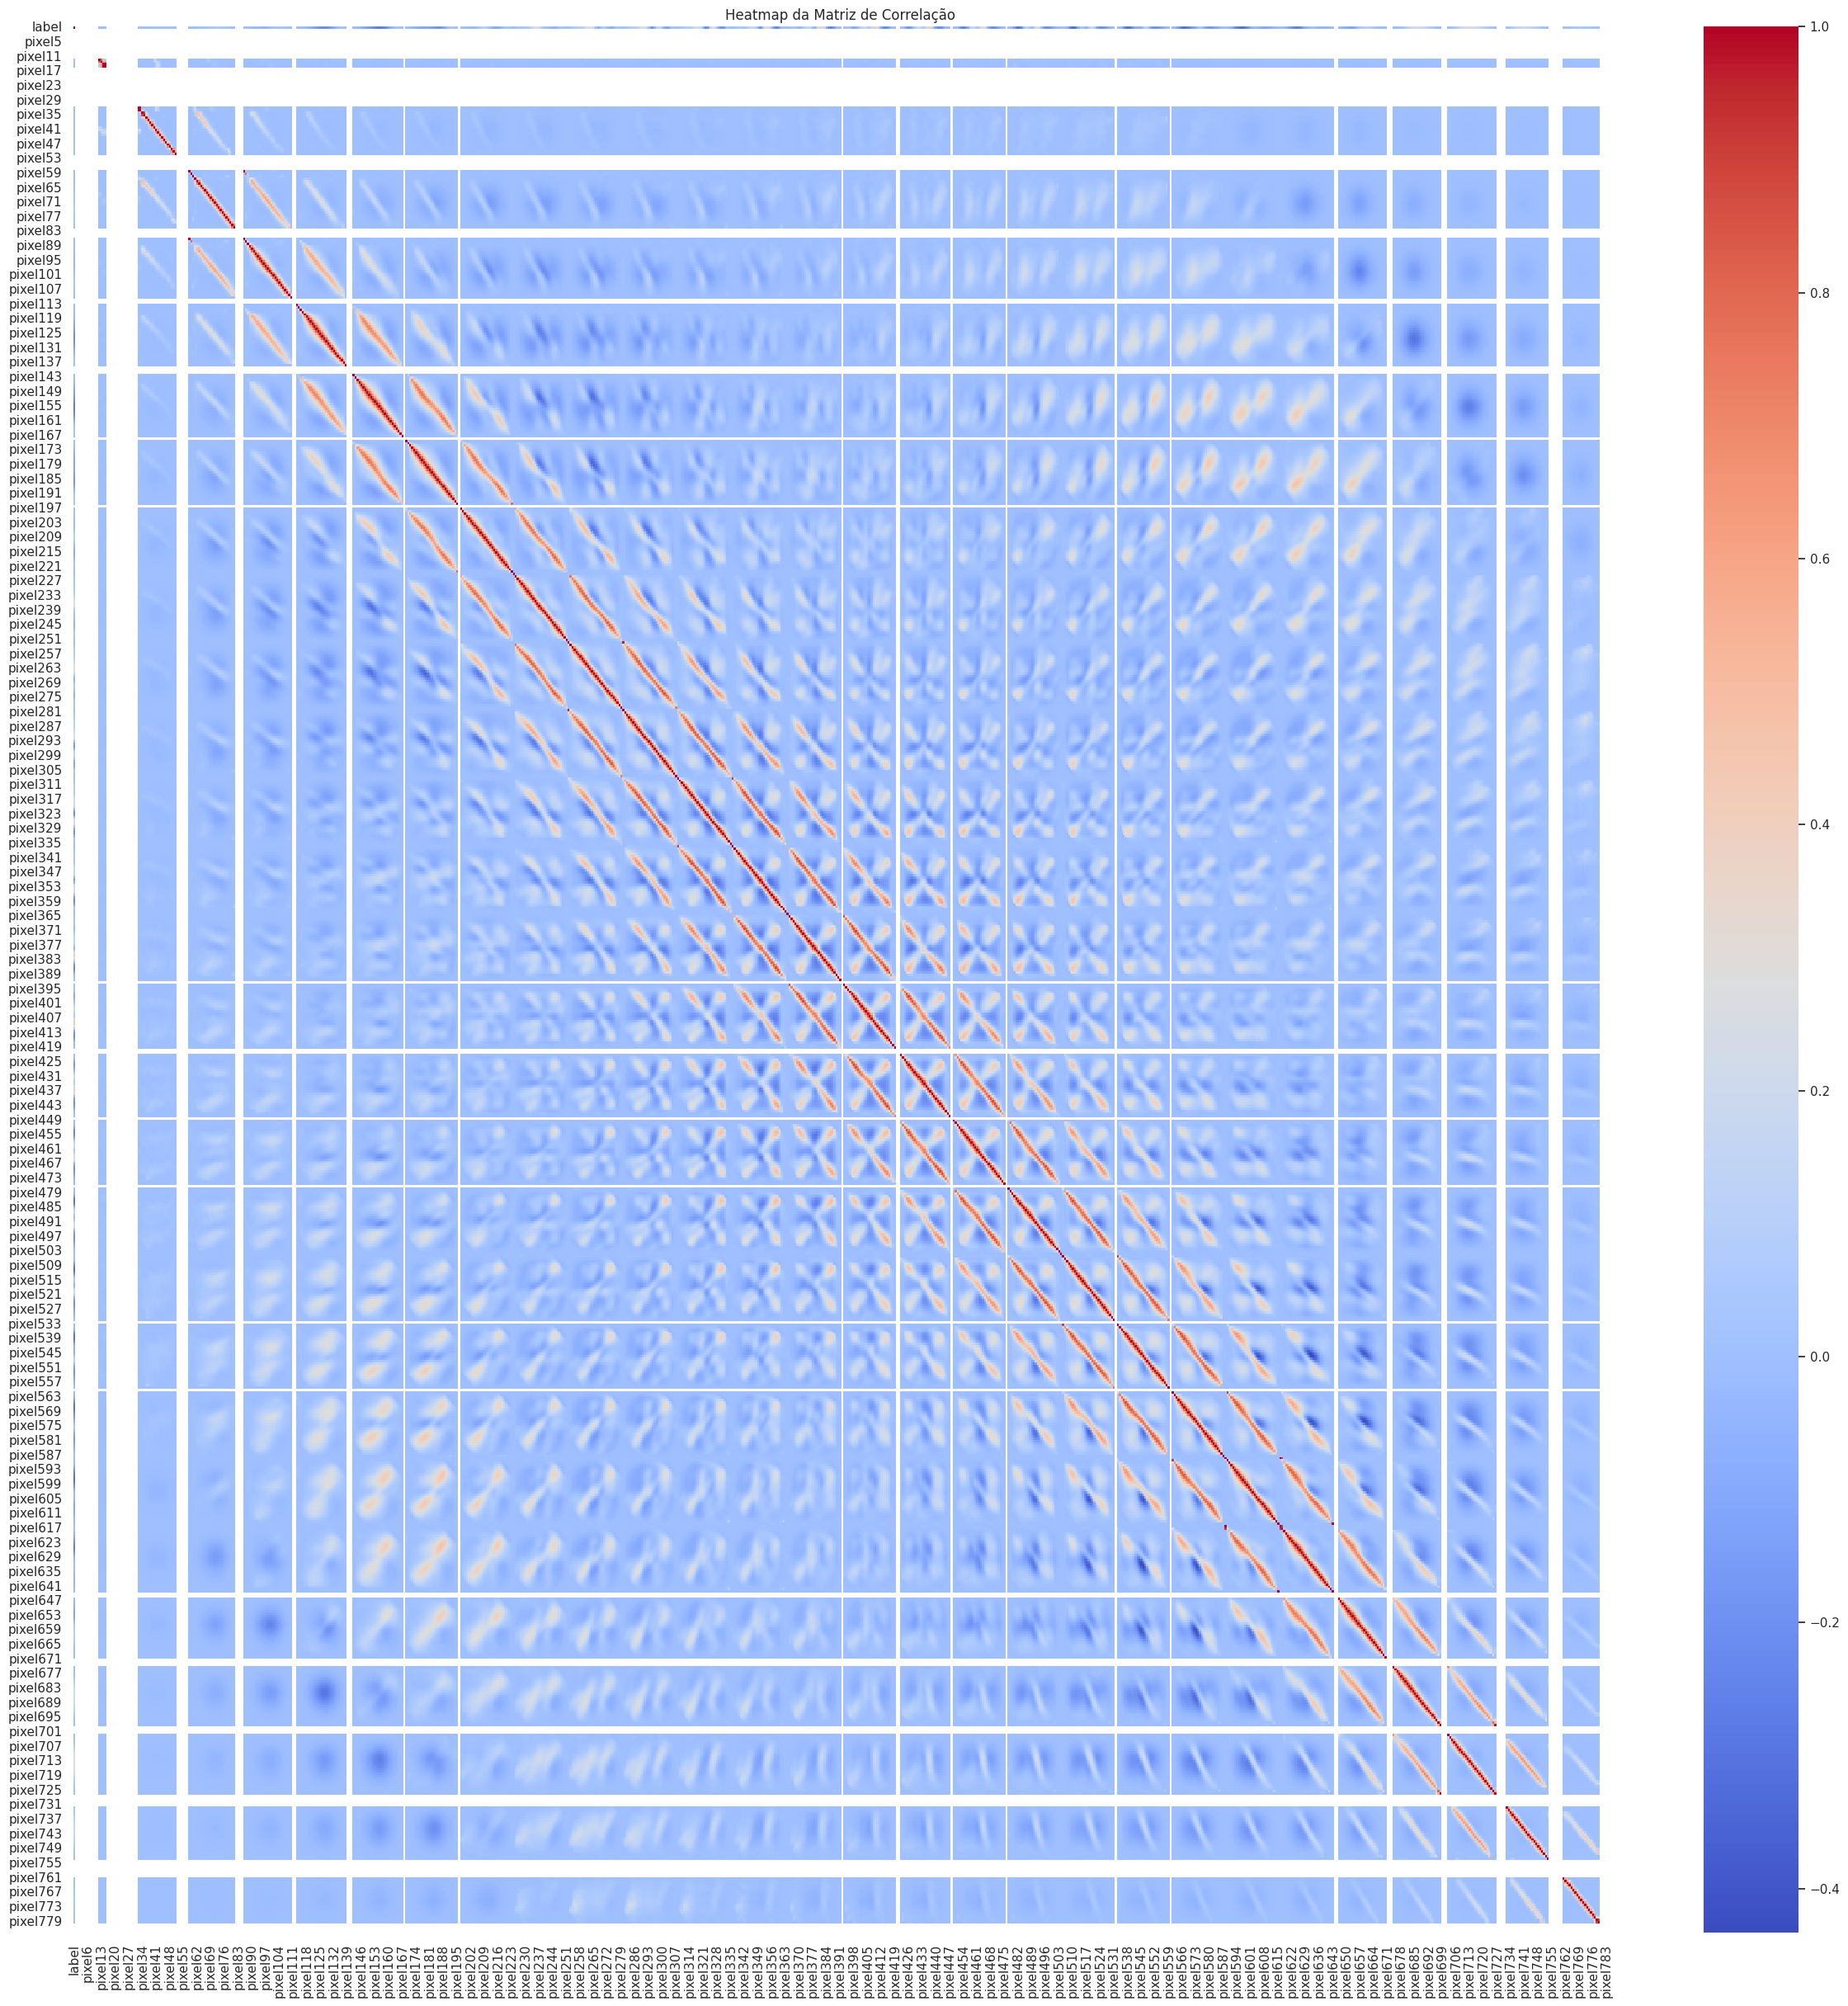

In [80]:
correlation_matrix = df.corr()

plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Heatmap da Matriz de Correlação')
plt.show()

In [81]:
# Verifica os dados
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [82]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [83]:
# Normaliza os dados
X_train  = X_train  / 255.0
test     = test     / 255.0

In [84]:
# Remodela a imagem em 3 dimensões (altura = 28px, largura = 28px, canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [85]:
# Codifica rótulos para um hot vector (ex: 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [86]:
# Defina a semente aleatória
random_seed = 2

In [87]:
# Divida o train e o conjunto de validação para o ajuste
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

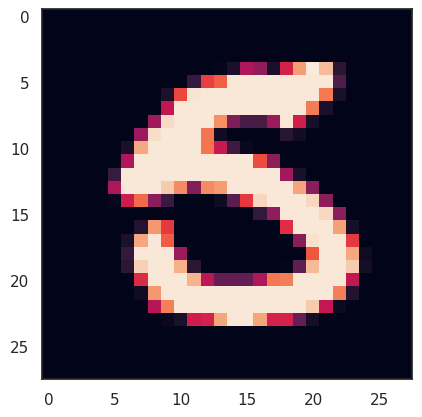

In [88]:
# exemplos
g = plt.imshow(X_train[4][:,:,0])

In [89]:
# Defina o modelo CNN

# Entrada -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Achatar -> Densa -> Dropout -> Saida

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [90]:
# Defina o otimizador
optimizer = RMSprop(
                     learning_rate=0.001,
                     rho=0.9,
                     epsilon=1e-08,
                     decay=0.0)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [91]:
# Compilar o modelo
model.compile(
               optimizer = optimizer,
               loss      = "categorical_crossentropy",
               metrics   = ["accuracy"])

In [92]:
# Definir um recozimento de taxa de aprendizagem
learning_rate_reduction = ReduceLROnPlateau(
                                             monitor   = "val_loss", 
                                             patience  = 3, 
                                             verbose   = 1, 
                                             factor    = 0.5, 
                                             min_lr    = 0.00001)

In [93]:
epochs = 30 # 30 para 0.9967 de acurácia
batch_size = 86

In [94]:
# Com aumento de dados para evitar overfitting (precisão 0,99286)

datagen = ImageDataGenerator(
                              featurewise_center            = False, # define a média de entrada como 0 no conjunto de dados
                              samplewise_center             = False, # define cada média amostral como 0
                              featurewise_std_normalization = False, # divide as entradas por padrão do conjunto de dados
                              samplewise_std_normalization  = False, # divide cada entrada pelo seu padrão
                              zca_whitening                 = False, # aplique o clareamento ZCA
                              rotation_range                = 10,    # gira imagens aleatoriamente no intervalo (graus, 0 a 180)
                              zoom_range                    = 0.1,   # Zoom aleatório na imagem
                              width_shift_range             = 0.1,   # desloca as imagens horizontalmente aleatoriamente (fração da largura total)
                              height_shift_range            = 0.1,   # desloca as imagens verticalmente aleatoriamente (fração da altura total)
                              horizontal_flip               = False, # vira imagens aleatoriamente
                              vertical_flip                 = False) # vira imagens aleatoriamente


datagen.fit(X_train)

In [95]:
# Ajuste o modelo
history = model.fit(
                     datagen.flow(
                                   X_train,
                                   Y_train, 
                                   batch_size=batch_size),
                     epochs = epochs, 
                     validation_data = (X_val,Y_val),
                     verbose = 2, 
                     steps_per_epoch=X_train.shape[0] // batch_size, 
                     callbacks=[learning_rate_reduction])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


439/439 - 123s - 281ms/step - accuracy: 0.8620 - loss: 0.4277 - val_accuracy: 0.9745 - val_loss: 0.0792 - learning_rate: 0.0010
Epoch 2/30


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


439/439 - 4s - 9ms/step - accuracy: 0.9302 - loss: 0.1760 - val_accuracy: 0.9805 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 3/30
439/439 - 121s - 277ms/step - accuracy: 0.9607 - loss: 0.1327 - val_accuracy: 0.9867 - val_loss: 0.0534 - learning_rate: 0.0010
Epoch 4/30
439/439 - 4s - 9ms/step - accuracy: 1.0000 - loss: 0.0114 - val_accuracy: 0.9871 - val_loss: 0.0495 - learning_rate: 0.0010
Epoch 5/30
439/439 - 121s - 275ms/step - accuracy: 0.9699 - loss: 0.0999 - val_accuracy: 0.9893 - val_loss: 0.0333 - learning_rate: 0.0010
Epoch 6/30
439/439 - 4s - 9ms/step - accuracy: 0.9884 - loss: 0.0592 - val_accuracy: 0.9883 - val_loss: 0.0364 - learning_rate: 0.0010
Epoch 7/30
439/439 - 122s - 278ms/step - accuracy: 0.9745 - loss: 0.0821 - val_accuracy: 0.9931 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 8/30
439/439 - 4s - 9ms/step - accuracy: 0.9884 - loss: 0.0342 - val_accuracy: 0.9871 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 9/30
439/439 - 121s - 276ms/step - accuracy: 0.9

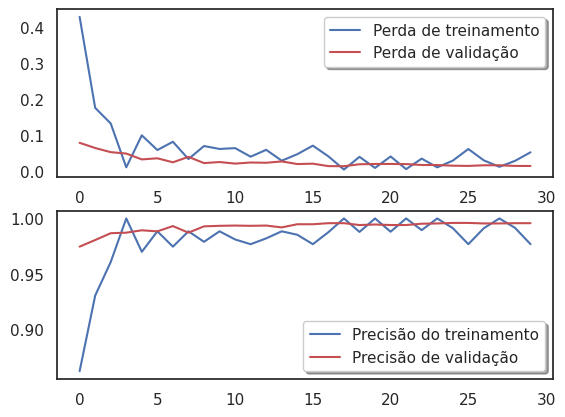

In [96]:
# Trace as curvas de perda e precisão para treinamento e validação
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'],         color='b', label="Perda de treinamento")
ax[0].plot(history.history['val_loss'],     color='r', label="Perda de validação",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'],     color='b', label="Precisão do treinamento")
ax[1].plot(history.history['val_accuracy'], color='r', label="Precisão de validação")


legend = ax[1].legend(loc='best', shadow=True)

132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


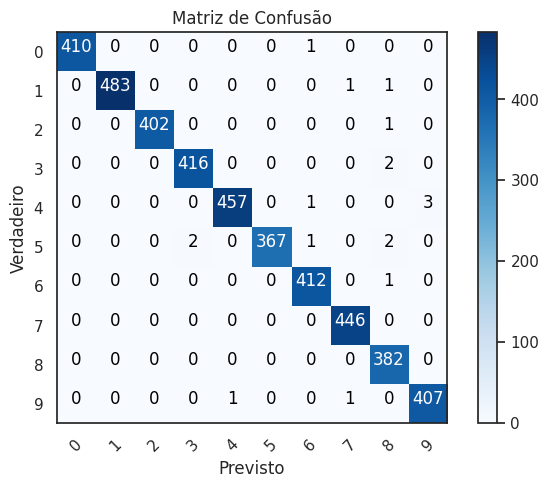

In [97]:
# Matriz de confusão

def plota_matriz_confusao(
                           cm, 
                           classes,
                           normalize  = False,
                           titulo     = 'Matriz de Confusão',
                           cmap       = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(titulo)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')

###
###    
    
# Prever os valores do conjunto de dados de validação
Y_pred = model.predict(X_val)

# Converta classes de predições em um hot vetor 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Converte observações de validação em um hot vetor
Y_true = np.argmax(Y_val,axis = 1) 

# calcula a matriz de confusão
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# traça a matriz de confusão
plota_matriz_confusao(confusion_mtx, classes = range(10)) 

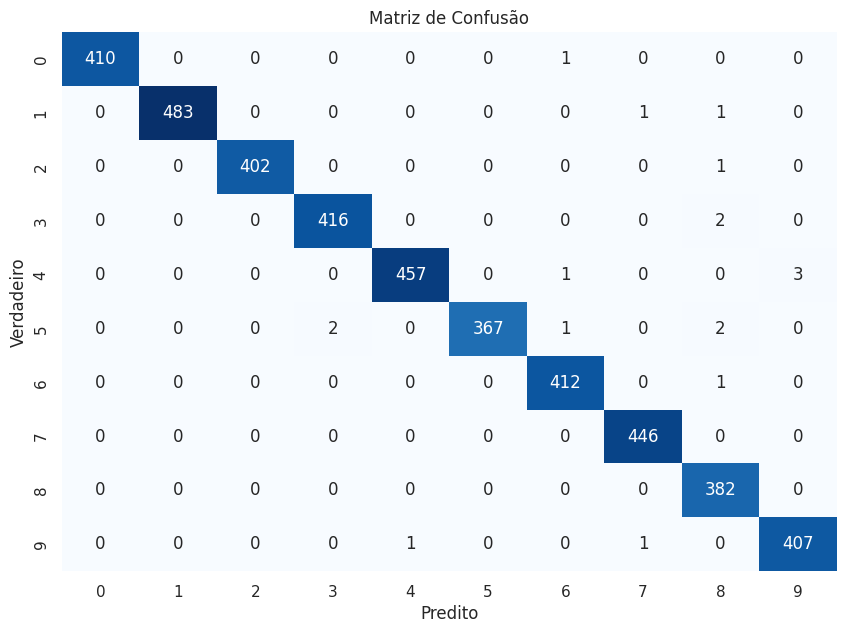

In [98]:
# Equivalente

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()